In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn import model_selection, preprocessing, metrics
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv("../datasets/ml-latest-small/ratings.csv")
df.rename(
    columns={"userId": "user_id", "movieId": "item_id", "timestamp": "ts"}, inplace=True
)
df.info()

stats_df = {
    "n_users": df.user_id.nunique(),
    "n_items": df.item_id.nunique(),
    "n_ratings": df.shape[0],
}

print("\n\n", pd.DataFrame(stats_df, index=[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  100836 non-null  int64  
 1   item_id  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   ts       100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


    n_users  n_items  n_ratings
1      610     9724     100836


rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64


<BarContainer object of 10 artists>

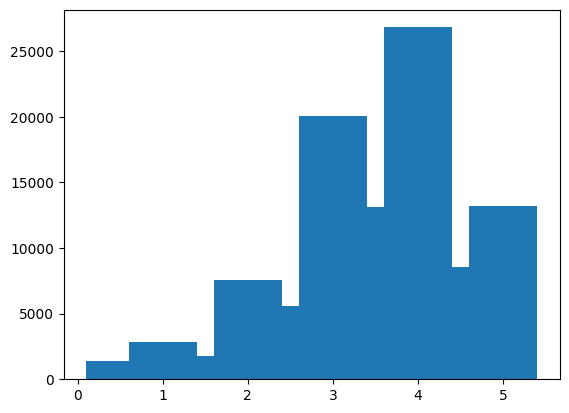

In [3]:
rating_dist = df.rating.value_counts()
print(rating_dist)
plt.bar(rating_dist.index, rating_dist.values)

#### **Predict Ratings**

In [4]:
class ItemDataset(Dataset):
    def __init__(self, users, items, targets):
        self.users = users
        self.items = items
        self.targets = targets

    def __len__(self):
        return len(self.users)

    def __getitem__(self, item):
        users = self.users[item]
        items = self.items[item]
        targets = self.targets[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "items": torch.tensor(items, dtype=torch.long),
            "targets": torch.tensor(targets, dtype=torch.long),
        }


class RecSysModel(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32):
        """
        emb_dim = 32

        item and user embeddings get concatenated, resulting in an embedding with 64d.

        layers (3): 64d - 32d - 16d (2 hidden layers + output layer / last hidden layer)
        """

        super().__init__()

        # learnable paramters - user and item embedding matrices
        # user embedding matrix size = n_users x emb_dim
        # item embedding matrix size = n_items x emb_dim
        self.user_matrix_embedding = nn.Embedding(n_users, emb_dim)
        self.item_matrix_embedding = nn.Embedding(n_items, emb_dim)

        # single linear layer: 64 -> 1
        self.output = nn.Linear(2 * emb_dim, 1)

    def forward(self, user_ids, item_ids, targets=None):
        """
        Zero hidden layers.

        All it does: for the 64d concatenated embedding, it outputs a single value that
        passes through a linear layer.
        """
        user_embeddings = self.user_matrix_embedding(user_ids)
        item_embeddings = self.item_matrix_embedding(item_ids)

        x = torch.cat([user_embeddings, item_embeddings], dim=1)
        output = self.output(x)

        return output

**Datasets construction**

In [5]:
# encode the user and item id to start from 0
# this prevents us from run into index out of bound "error" with Embedding lookup
lbl_user = preprocessing.LabelEncoder()
lbl_item = preprocessing.LabelEncoder()

df.user_id = lbl_user.fit_transform(df.user_id.values)
df.item_id = lbl_item.fit_transform(df.item_id.values)

In [18]:
df_train, df_test = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.values
)

train_dataset = ItemDataset(
    users=df_train.user_id.values,
    items=df_train.item_id.values,
    targets=df_train.rating.values,
)

test_dataset = ItemDataset(
    users=df_test.user_id.values,
    items=df_test.item_id.values,
    targets=df_test.rating.values,
)

print(
    "Lengths: train set = {}; test set = {}".format(
        len(train_dataset), len(test_dataset)
    )
)

Lengths: train set = 90752; test set = 10084


In [ ]:
"""
total number of batches = nb. training points / batch_size
"""

train_loader = DataLoader(
    dataset=train_dataset, batch_size=4, shuffle=True, num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset, batch_size=4, shuffle=True, num_workers=2
)

dataiter = iter(train_loader)
print(next(dataiter))

{'users': tensor([605, 356, 447, 368]), 'items': tensor([3790, 7626, 5246, 3557]), 'targets': tensor([2, 5, 3, 4])}


In [20]:
n_users = len(lbl_user.classes_)
n_items = len(lbl_item.classes_)

model = RecSysModel(n_users=n_users, n_items=n_items).to(device)

optimizer = torch.optim.Adam(model.parameters())

# Every `step_size` calls to scheduler.step(), multiply the learning rate by `gamma`
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [21]:
print("n_users: {}; n_items: {} \n".format(n_users, n_items))

for p in model.parameters():
    print(p.shape)

"""
Parameters
----------
user_matrix_embedding.weight  torch.Size([n_users, 32])
item_matrix_embedding.weight  torch.Size([n_items, 32])
output.weight                 torch.Size([1, 64])
output.bias                   torch.Size([1])
"""

n_users: 610; n_items: 9724 

torch.Size([610, 32])
torch.Size([9724, 32])
torch.Size([1, 64])
torch.Size([1])


'\nParameters\n----------\nuser_matrix_embedding.weight  torch.Size([n_users, 32])\nitem_matrix_embedding.weight  torch.Size([n_items, 32])\noutput.weight                 torch.Size([1, 64])\noutput.bias                   torch.Size([1])\n'

**Forward Pass Example**

**Training Loop**

In [ ]:
epochs = 2  # nb. of times we go through the train set
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = []

model.train()
"""
- Puts the model into "training mode"

- It changes how some layers behave:
    1. Dropout layers (nn.Dropout)
        - In train() mode: randomly zero out some activations (adds noise, regularizes).
        - In eval() mode: no dropout, they pass everything through (but scaled 
        appropriately during training).

    2. BatchNorm layers (nn.BatchNorm1d, nn.BatchNorm2d, etc.)
        (it fixes the "internal covariate shift" problem)
        - In train() mode: use the current batch's mean/variance and update running stats.
        - In eval() mode: use the stored running mean/variance (fixed statistics).
"""


for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        # move data to device
        users = train_data["users"].to(device)
        items = train_data["items"].to(device)
        targets = train_data["targets"].to(device)

        # foward pass
        pred_target = model(users, items)
        true_target = targets.view(targets.size(0), -1).to(torch.float32)
        loss = loss_func(pred_target, true_target)
        total_loss += loss.sum().item()

        # clears old gradients from previous iteration
        optimizer.zero_grad()
        # backpropagation: performs backward propragation
        # (fills param.grad for every parameter in model.parameters())
        loss.backward()
        # param update: uses the gradients in param.grads to update the parameters
        optimizer.step()

        step_cnt += len(train_data["users"])

        # for plot purposes
        if step_cnt % plot_steps == 0:
            avg_loss = total_loss / (len(train_data["users"]) * plot_steps)
            print("epoch {} loss at step {} os {}".format(epoch_i, step_cnt, avg_loss))
            all_losses_list.append(avg_loss)
            total_loss = 0  # reset total loss

epoch 0 loss at step 5000 os 0.46052838924229145
epoch 0 loss at step 10000 os 0.17358762497380376
epoch 0 loss at step 15000 os 0.10670360562205315
epoch 0 loss at step 20000 os 0.08310328462719917
epoch 0 loss at step 25000 os 0.0734397054715082
epoch 0 loss at step 30000 os 0.06874039593106136
epoch 0 loss at step 35000 os 0.0634705493790796
epoch 0 loss at step 40000 os 0.061442830081493593
epoch 0 loss at step 45000 os 0.06015329384809011
epoch 0 loss at step 50000 os 0.0618278965163976
epoch 0 loss at step 55000 os 0.05916961690252647
epoch 0 loss at step 60000 os 0.05940275353966281
epoch 0 loss at step 65000 os 0.06000730852289125
epoch 0 loss at step 70000 os 0.05770829218477011
epoch 0 loss at step 75000 os 0.05813771018073894
epoch 0 loss at step 80000 os 0.059274191934475674
epoch 0 loss at step 85000 os 0.0565379197179107
epoch 0 loss at step 90000 os 0.05825023988650646
epoch 1 loss at step 95000 os 0.05531437770295888
epoch 1 loss at step 100000 os 0.05351281363693997
ep

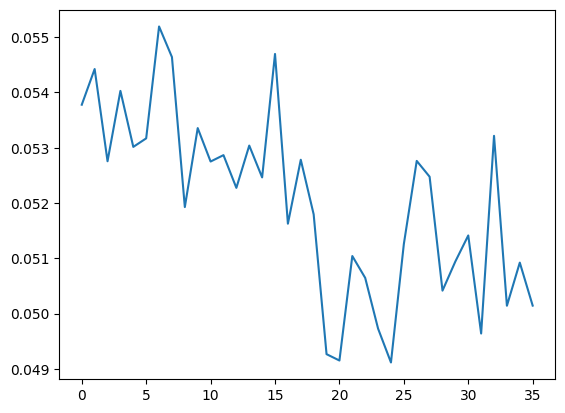

In [19]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

**Evaluation Loop w/ RMSE**

In [30]:
from sklearn.metrics import root_mean_squared_error

pred_target_list = []
true_target_list = []
verbose = False

model.eval()
with torch.no_grad():  # Don’t track gradients and don’t build a computation graph
    for i, test_data in enumerate(test_loader):
        # move data to device
        users = test_data["users"].to(device)
        items = test_data["items"].to(device)
        targets = test_data["targets"].to(device)

        pred_target = model(users, items)
        true_target = targets.view(targets.size(0), -1).to(torch.float32)

        pred_target_list.append(pred_target.sum().item() / len(users))
        true_target_list.append(true_target.sum().item() / len(users))

        if verbose:
            print("Prediction: {}; True: {}".format(pred_target, true_target))

rmse = root_mean_squared_error(true_target_list, pred_target_list)
print("RMSE: {}".format(np.round(rmse, 4)))

RMSE: 0.4708
